In [61]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [62]:
res = gpd.read_file(r'../Data/processed/manhattan_residential.geojson')

In [63]:
manhattan = gpd.read_file(r'../Data/processed/manhattan_buildings.geojson')

In [64]:
# res = manhattan[(manhattan['CURTAXCLASS'].isin([1, 2]))].copy()

In [65]:
res.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'geometry'],
      dtype='object')

In [ ]:
# clustering 1
K = 5
RANDOM_STATE = 42


In [ ]:
def kmeans_and_profile_fast(df, k=6, random_state=42, weights=None, stats=("min","median","mean","max")):
    feat_cols = [
        "elevator_flag",
        "price_per_sqft",
        "time_taken",
        "height_roof",
        "res_share",
    ]
    
    weights = np.array([
        1,   # elevator_flag
        1,   # price_per_sqft
        3,   # time_taken
        3,   # height_roof
        1,   # res_share
    ], dtype=np.float32)

    missing = [c for c in feat_cols if c not in df.columns]

    df[feat_cols] = (
        df[feat_cols]
        .apply(pd.to_numeric, errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .astype(np.float32)
    )
    X = df[feat_cols].to_numpy(dtype=np.float32)

    imp = SimpleImputer(strategy="median")
    X_imp = imp.fit_transform(X).astype(np.float32)

    q01 = np.nanpercentile(X_imp, 1, axis=0)
    q99 = np.nanpercentile(X_imp, 99, axis=0)
    X_clip = np.clip(X_imp, q01, q99).astype(np.float32)

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_clip).astype(np.float32)

    X_w = (X_scaled * weights).astype(np.float32)

    km = KMeans(n_clusters=k, n_init=10, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(X_w)

    # --- Stable relabeling by mean height_roof ---
    label_order = (
        pd.DataFrame({"label": labels, "height_roof": df["height_roof"]})
        .groupby("label")["height_roof"]
        .mean()
        .sort_values()
        .index
        .tolist()
    )
    remap = {old: new for new, old in enumerate(label_order)}
    labels = np.array([remap[l] for l in labels], dtype=np.int32)

    df = df.assign(kmeans_label=labels)

    all_df = km.transform(X_w).astype(np.float32)
    chosen_df = all_df[np.arange(all_df.shape[0]), km.labels_]
    r90 = {c: np.nanpercentile(chosen_df[labels == c], 90) for c in range(k)}
    r95 = {c: np.nanpercentile(chosen_df[labels == c], 95) for c in range(k)}
    conf = 1.0 - np.minimum(
        chosen_df / np.array([r90[c] for c in labels], dtype=np.float32),
        1.0
    )
    df = df.assign(cluster_confidence=conf.astype(np.float32))

    X_clip_df = pd.DataFrame(X_clip, columns=feat_cols, index=df.index)
    X_clip_df["kmeans_label"] = labels
    agg = {c: list(stats) for c in feat_cols}
    prof = X_clip_df.groupby("kmeans_label").agg(agg)
    prof[("n","count")] = X_clip_df.groupby("kmeans_label").size()
    cols = [("n","count")] + [c for c in prof.columns if c != ("n","count")]
    prof = prof.reindex(columns=cols)

    return {
        "data": df,
        "model": km,
        "scaler": scaler,
        "imputer": imp,
        "feature_weights": dict(zip(feat_cols, weights.tolist())),
        "cluster_profile": prof,
        "r90": r90,
        "r95": r95,
    }


In [68]:
results = kmeans_and_profile_fast(res, k=K, random_state=RANDOM_STATE)
manhattan_k = results["data"]
profile = results["cluster_profile"]

In [69]:
print(profile['elevator_flag'])

              min  median      mean  max
kmeans_label                            
0             0.0     0.0  0.138831  1.0
1             0.0     0.0  0.294185  1.0
2             0.0     0.0  0.281382  1.0
3             0.0     1.0  0.917239  1.0
4             0.0     1.0  0.950859  1.0


In [70]:
print(profile['height_roof'])

                     min      median        mean         max
kmeans_label                                                
0              14.150562   46.057304   48.280895  107.580002
1              14.150562   59.000000   59.932655  126.050003
2              14.150562   60.590000   60.972473  113.769997
3             111.980003  162.160004  164.029297  246.000000
4             249.663010  332.209991  332.544006  390.000000


In [71]:
print(profile['price_per_sqft'])

                     min       median         mean          max
kmeans_label                                                   
0             755.430420  2047.368408  2133.099609  3217.528809
1              33.828571   242.292938   308.668304  2536.824707
2              33.828571   233.234940   284.044434  1492.037598
3              33.828571   224.056931   216.421082  3217.528809
4              33.828571   258.627960   241.794235   581.089294


In [72]:
print(profile['res_share'])

              min    median      mean  max
kmeans_label                              
0             0.0  0.000000  0.022841  1.0
1             0.0  0.956349  0.788373  1.0
2             0.0  0.925926  0.774326  1.0
3             0.0  0.963180  0.927894  1.0
4             0.0  0.899918  0.836056  1.0


In [73]:
print(profile['time_taken'])

                   min    median      mean        max
kmeans_label                                         
0             0.969301  4.538734  4.837496  13.641393
1             6.284426  8.017958  8.680680  14.488052
2             0.969301  4.051434  4.035316   6.498503
3             0.969301  4.937326  5.507509  14.488052
4             0.969301  5.001414  5.693240  14.488052


In [74]:
cluster_names = {
    0: "Mixed-Use Luxury Walk-Ups",
    1: "Peripheral Walk-Ups",
    2: "Transit-Accessible Affordable Walk-Ups",
    3: "Elevator Mid/High-Rises",
    4: "Affordable Residential Towers"
}

# Apply mapping to your dataframe
results["data"]["cluster_name"] = results["data"]["kmeans_label"].map(cluster_names)

# Also add to profile for easier readability
profile_named = results["cluster_profile"].copy()
profile_named.index = profile_named.index.map(cluster_names)

In [75]:
res_socio = results['data']
res_socio.columns

Index(['base_bbl', 'construction_year', 'height_roof', 'bin', 'CURTAXCLASS',
       'CURMKTTOT', 'PYMKTTOT', 'GROSS_SQFT', 'RESIDENTIAL_AREA_GROSS',
       'BLD_STORY', 'ZONING', 'BLDG_CLASS', 'price_per_sqft',
       'price_per_sqft_2024', 'time_taken', 'elevator', 'unitsres',
       'res_share', 'elevator_flag', 'geometry', 'kmeans_label',
       'cluster_confidence', 'cluster_name'],
      dtype='object')

In [80]:
res_socio['cluster_name'].value_counts()

cluster_name
Transit-Accessible Affordable Walk-Ups    97071
Peripheral Walk-Ups                       42718
Mixed-Use Luxury Walk-Ups                 30015
Elevator Mid/High-Rises                   29555
Affordable Residential Towers              8262
Name: count, dtype: int64

In [43]:
# res_socio = res_socio.to_crs(4326)
# residential = res_socio[[
#     'construction_year', 'height_roof', 'CURMKTTOT',
#     'CURTAXCLASS', 'price_per_sqft', 'BLD_STORY', 'ZONING', 
#     'BLDG_CLASS', 'time_taken', 'unitsres', 'elevator_flag',
#     'res_share', 'unit_density', 'unitsize', 'geometry'
#     ]]

# residential["geometry"] = residential.geometry.simplify(0.00002, preserve_topology=True)
# residential["fid"] = np.arange(len(residential))
# residential.to_file("manhattan_metrics.geojson", driver="GeoJSON")

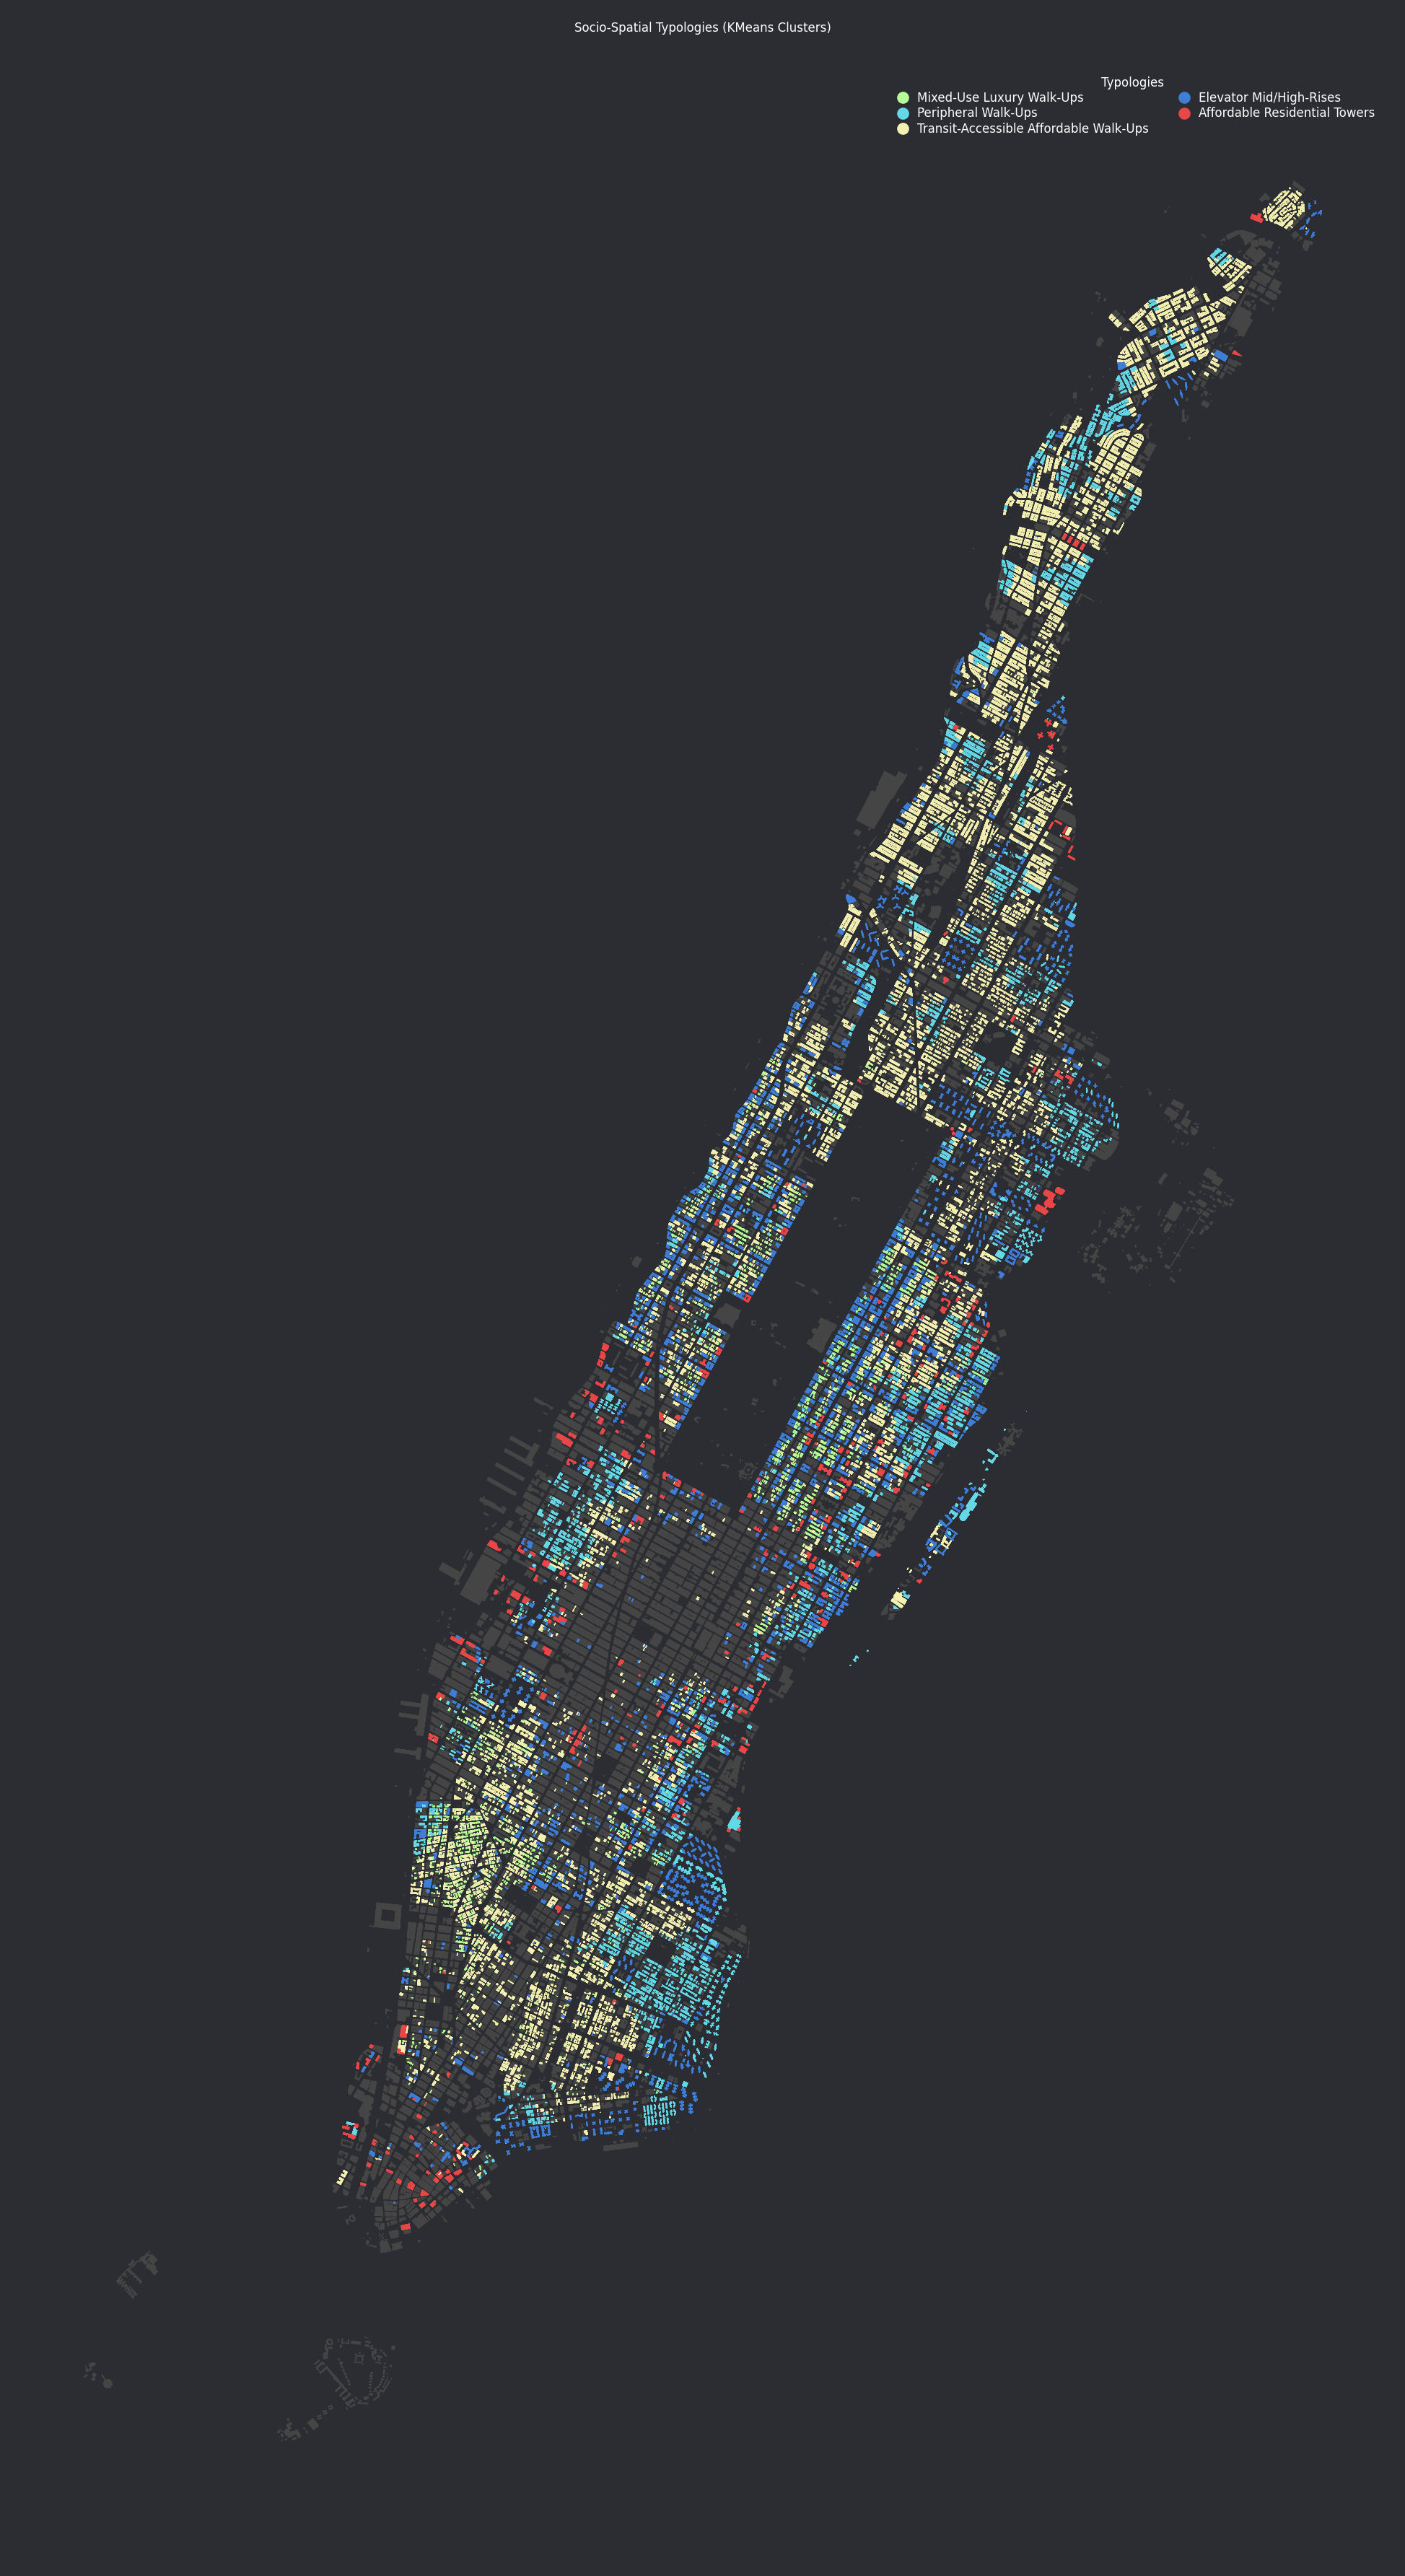

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pandas.api.types import CategoricalDtype

# --- base layers ---
nonres = manhattan[~manhattan['CURTAXCLASS'].isin([1, 2])]

# define the 6 cluster labels in order
cluster_labels = [
    "Mixed-Use Luxury Walk-Ups",
    "Peripheral Walk-Ups",
    "Transit-Accessible Affordable Walk-Ups",
    "Elevator Mid/High-Rises",
    "Affordable Residential Towers"
]

# mapping dictionary (0–5 → name)
cluster_names = dict(enumerate(cluster_labels))

# assign cluster names into your residential dataframe
# assumes you already have a column "kmeans_label" in res_socio
res_socio["bldg_cat_socio_spatial"] = res_socio["kmeans_label"].map(cluster_names)

# custom colors for the 6 clusters
custom_colors = {
    "Mixed-Use Luxury Walk-Ups":                   "#b6fd96",
    "Peripheral Walk-Ups":                         "#65d8e7",
    "Transit-Accessible Affordable Walk-Ups":      "#f4f0b1",
    "Elevator Mid/High-Rises":                     "#3F7ED7",
    "Affordable Residential Towers":               "#e74747",
}

# enforce categorical order
cat_dtype = CategoricalDtype(categories=cluster_labels, ordered=True)
res_socio["bldg_cat_socio_spatial"] = res_socio["bldg_cat_socio_spatial"].astype(cat_dtype)

# colormap in the same order as cluster_labels
color_list = [custom_colors[c] for c in cluster_labels]
cmap = ListedColormap(color_list)

# ---- plot ----
fig, ax = plt.subplots(figsize=(10, 12), dpi=300, facecolor="#2B2D32")

# 1) BASE: non-residential in black
nonres.plot(ax=ax, color="#454545", linewidth=0, edgecolor="none")

# 2) RESIDENTIAL: 6 clusters
res_socio.plot(
    ax=ax,
    column="bldg_cat_socio_spatial",
    cmap=cmap,
    linewidth=0,
    edgecolor="none",
    legend=True,
    categorical=True,
    legend_kwds={
        "title": "Typologies",
        "fontsize": 4,
        "title_fontsize": 4,
        "ncol": 2,
        "markerscale": 0.4,
        "handletextpad": 0.2,
        "labelspacing": 0.2,
        "borderpad": 0.2,
        "frameon": False,
    },
)

ax.set_title("Socio-Spatial Typologies (KMeans Clusters)", color="white", fontsize=4, pad=12)
ax.set_axis_off()

leg = ax.get_legend()
if leg:
    for txt in leg.get_texts():
        txt.set_color("white")
    if leg.get_title() is not None:
        leg.get_title().set_color("white")

plt.tight_layout()
plt.show()
